<h1 style="text-align:center;font-size: 4em"> Préparation des données </h1>

Le but de cette étude est de proposer un modèle de prédiction de la réadmission non planifiée à 30 jours chez les patients diabétiques dans les hôpitaux américains en utilisant les données générées par le Data Warehouse. L’analyse sera basée sur des facteurs de risque tels que les données démographiques du patient, les détails d’admission, le diagnostic et les données médicales. Dans un sens plus large, le but de l'étude est de permettre aux centres de santé de mieux anticiper et traiter les réadmissions non planifiées tout en améliorant la qualité de leurs soins et leur rentabilité.

### Importer des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Importer le fichier CSV extrait de DWH

In [2]:
df2 = pd.read_csv('CSV_Files/out.csv')
df2.head()

,RACE,GENDER,AGE_INT,ADMISSION_TYPE,DISCHARGE_DISPOSITION,ADMISSION_SOURCE,TIME_IN_HOSPITAL,PAYER_CODE,MEDICAL_SPECIALTY,NUM_LAB_PROCEDURES,NUM_PROCEDURES,NUM_MEDICATIONS,NUMBER_OUTPATIENT,NUMBER_EMERGENCY,NUMBER_INPATIENT,DIAG_1,DIAG_2,DIAG_3,NUMBER_DIAGNOSES,MAX_GLU_SERUM,A1CRESULT,METFORMIN,REPAGLINIDE,NATEGLINIDE,CHLORPROPAMIDE,GLIMEPIRIDE,ACETOHEXAMIDE,GLIPIZIDE,GLYBURIDE,TOLBUTAMIDE,PIOGLITAZONE,ROSIGLITAZONE,ACARBOSE,MIGLITOL,TROGLITAZONE,TOLAZAMIDE,EXAMIDE,CITOGLIPTON,INSULIN,GLYBURIDE_METFORMIN,GLIPIZIDE_METFORMIN,GLIMEPIRIDE_PIOGLITAZONE,METFORMIN_ROSIGLITAZONE,METFORMIN_PIOGLITAZONE,CHANGE,DIABETESMED,READMITTED
0,Caucasian,Female,65,Urgent,Discharged to home,Physician Referral,3,MC,Nephrology,59,3,11,0,0,0,SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUE...,403,599,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
1,Caucasian,Female,75,Emergency,Discharged/transferred to another rehab fac in...,Emergency Room,7,MC,Orthopedics-Reconstructive,58,2,15,0,0,0,821,276,285,9,None,None,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
2,Caucasian,Female,95,Emergency,Discharged to home,Emergency Room,4,MC,Emergency/Trauma,56,1,9,0,0,0,532,428,535,6,None,None,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,75,Emergency,Discharged/transferred to another short term h...,Emergency Room,10,MC,InternalMedicine,68,1,18,0,0,0,682,427,276,6,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,55,Emergency,Left AMA,Transfer from another health care facility,6,MC,Nephrology,52,3,17,0,0,0,578,250.41,403,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30


In [3]:
df2.columns

Index(['RACE', 'GENDER', 'AGE_INT', 'ADMISSION_TYPE', 'DISCHARGE_DISPOSITION',
       'ADMISSION_SOURCE', 'TIME_IN_HOSPITAL', 'PAYER_CODE',
       'MEDICAL_SPECIALTY', 'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES',
       'NUM_MEDICATIONS', 'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY',
       'NUMBER_INPATIENT', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'NUMBER_DIAGNOSES',
       'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE',
       'CHLORPROPAMIDE', 'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE',
       'GLYBURIDE', 'TOLBUTAMIDE', 'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE',
       'MIGLITOL', 'TROGLITAZONE', 'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON',
       'INSULIN', 'GLYBURIDE_METFORMIN', 'GLIPIZIDE_METFORMIN',
       'GLIMEPIRIDE_PIOGLITAZONE', 'METFORMIN_ROSIGLITAZONE',
       'METFORMIN_PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED'],
      dtype='object')

### Exploration et nettoyage des données pour appliquer les modèles de machine learning
On va effectuer des tâches supplémentaire de nettoyage des données telles que la suppression de mauvaises données, le traitement des valeurs manquantes...

In [4]:
df2.shape

(26755, 47)

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26755 entries, 0 to 26754
Data columns (total 47 columns):
RACE                        26755 non-null object
GENDER                      26755 non-null object
AGE_INT                     26755 non-null int64
ADMISSION_TYPE              26752 non-null object
DISCHARGE_DISPOSITION       26749 non-null object
ADMISSION_SOURCE            25935 non-null object
TIME_IN_HOSPITAL            26755 non-null int64
PAYER_CODE                  26755 non-null object
MEDICAL_SPECIALTY           26755 non-null object
NUM_LAB_PROCEDURES          26755 non-null int64
NUM_PROCEDURES              26755 non-null int64
NUM_MEDICATIONS             26755 non-null int64
NUMBER_OUTPATIENT           26755 non-null int64
NUMBER_EMERGENCY            26755 non-null int64
NUMBER_INPATIENT            26755 non-null int64
DIAG_1                      26755 non-null object
DIAG_2                      26755 non-null object
DIAG_3                      26755 non-null object

Il y a 47 caractéristiques dans ces données. Il contient des valeurs numériques (int) et des valeurs catégorielles (objet).

Il y a 26755 échantillons présents dans cet ensemble de données. Il ne semble pas y avoir de valeurs nulles, nous allons creuser profondément et en savoir plus.

In [6]:
df2.describe()

,AGE_INT,TIME_IN_HOSPITAL,NUM_LAB_PROCEDURES,NUM_PROCEDURES,NUM_MEDICATIONS,NUMBER_OUTPATIENT,NUMBER_EMERGENCY,NUMBER_INPATIENT,NUMBER_DIAGNOSES
count,26755.000000,26755.000000,26755.000000,26755.000000,26755.000000,26755.000000,26755.000000,26755.000000,26755.000000
mean,66.608671,4.317922,40.756681,1.475575,16.246720,0.290712,0.311755,0.670641,7.355522
std,15.582391,2.949791,19.965546,1.749729,8.609362,0.998707,1.437214,1.367311,1.895473
min,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,55.000000,2.000000,29.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,65.000000,4.000000,42.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,75.000000,6.000000,54.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,95.000000,14.000000,132.000000,6.000000,81.000000,38.000000,76.000000,16.000000,16.000000


       'RACE', 'GENDER', 'AGE_INT', 'ADMISSION_TYPE', 'DISCHARGE_DISPOSITION',
       'ADMISSION_SOURCE', 'TIME_IN_HOSPITAL', 'PAYER_CODE',
       'MEDICAL_SPECIALTY', 'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES',
       'NUM_MEDICATIONS', 'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY',
       'NUMBER_INPATIENT', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'NUMBER_DIAGNOSES',
       'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE',
       'CHLORPROPAMIDE', 'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE',
       'GLYBURIDE', 'TOLBUTAMIDE', 'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE',
       'MIGLITOL', 'TROGLITAZONE', 'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON',
       'INSULIN', 'GLYBURIDE_METFORMIN', 'GLIPIZIDE_METFORMIN',
       'GLIMEPIRIDE_PIOGLITAZONE', 'METFORMIN_ROSIGLITAZONE',
       'METFORMIN_PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED'

Nous avons 47 variables, alors jetons un coup d'œil à chacun.

#### 1. RACE :  C'est une variable catégorielle.

Caucasian          20183
AfricanAmerican     5359
Hispanic             487
Other                476
Asian                250
Name: RACE, dtype: int64


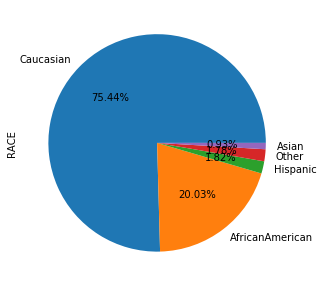

In [7]:
print(df2['RACE'].value_counts())
df2['RACE'].value_counts().plot(kind='pie',autopct='%.2f%%',figsize=(15,5))
plt.show()

Il y a 5 catégories distinctes pour la variable RACE.

Pour le remplissage des valeurs nulles, nous avons essayé de remplacer par mode, en effectuant une substitution selon la distribution prob, en supprimant les valeurs nulles mais en supprimant les valeurs nulles semblant obtenir les meilleurs résultats.

In [8]:
df2 = df2.dropna()

In [9]:
df2.shape

(25926, 47)


#### 2. GENDER: C'est une caractéristique catégorique représentant le sexe du patient.

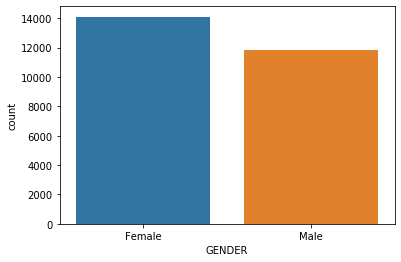

Female    14101
Male      11825
Name: GENDER, dtype: int64


In [10]:
sns.countplot(df2.GENDER)
plt.show()
print(df2.GENDER.value_counts())

Il y a 2 catégories ici: femme, homme.

In [11]:
#encoding gender
df2['GENDER'] = df2['GENDER'].replace({'Female' : 0, 'Male' : 1})

#### 3. AGE_INT: C'est l'age du personne; on a déja traiter ces valeurs avec SQL 

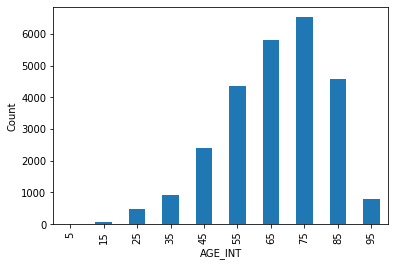

In [12]:
# check 'age' feature
df2.groupby('AGE_INT').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

L'âge ici varie de 0 à 100 ans.


La population comprise entre 50 et 90 ans est principalement présente dans cet ensemble de données.

#### 4. ADMISSION_TYPE : Identifiant correspondant à des valeurs distinctes, par exemple, urgence, urgent, électif, nouveau-né et non disponible.

In [13]:
df2.ADMISSION_TYPE.nunique()

5

Pour une analyse plus approfondie, nous pouvons fusionner ces catégories en moins de catégories.


Emeregncy/Urgent/Trauma Center ---> Emergency

In [14]:
df2['ADMISSION_TYPE']=df2['ADMISSION_TYPE'].replace({'Urgent':'Emergency','Emergency':'Emergency'})

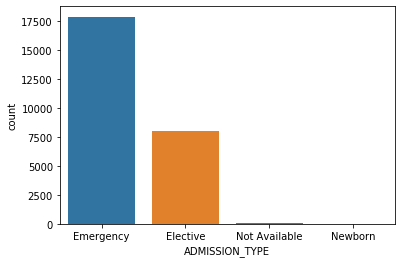

In [15]:
sns.countplot(df2['ADMISSION_TYPE'])
plt.show()

De là, nous pouvons voir que la majorité des patients qui ont été admis dans cet hôpital ont un type d'admission en urgence.

In [16]:
df2[df2['ADMISSION_TYPE']== 'Newborn'][['GENDER','AGE_INT','ADMISSION_TYPE']]

,GENDER,AGE_INT,ADMISSION_TYPE
4665,1,65,Newborn


Supprimer la catégorie newborn parce que  ADMISSION_TYPE == newborn et l'âge et le sexe qui y correspondent donnent des informations contradictoires.

In [17]:
df2=df2[df2['ADMISSION_TYPE']!='Newborn']

In [18]:
df2.ADMISSION_TYPE.value_counts()

Emergency        17874
Elective          8014
Not Available       37
Name: ADMISSION_TYPE, dtype: int64


#### 5. DISCHARGE_DISPOSITION: Identifiant entier correspondant à 26 valeurs distinctes, par exemple, déchargé vers le domicile, expiré et non disponible

In [19]:
df2.DISCHARGE_DISPOSITION.value_counts()

Discharged to home                                                                                           16621
Discharged/transferred to SNF                                                                                 4047
Discharged/transferred to home with home health service                                                       2527
Discharged/transferred to another rehab fac including rehab units of a hospital .                              781
Discharged/transferred to another short term hospital                                                          593
Expired                                                                                                        426
Discharged/transferred to another type of inpatient care institution                                           225
Discharged/transferred to ICF                                                                                  222
Left AMA                                                                        

#### discharge_disposition_id	description

1	Discharged to home

2	Discharged/transferred to another short term hospital

3	Discharged/transferred to SNF(skilled nursing facility)

4	Discharged/transferred to ICF(intermediate care facility)

5	Discharged/transferred to another type of inpatient care institution

6	Discharged/transferred to home with home health service

7	Left AMA(Against Medical Advice.)

8	Discharged/transferred to home under care of Home IV provider

9	Admitted as an inpatient to this hospital

10	Neonate discharged to another hospital for neonatal aftercare

11	Expired

12	Still patient or expected to return for outpatient services

13	Hospice / home

14	Hospice / medical facility

15	Discharged/transferred within this institution to Medicare approved swing bed

16	Discharged/transferred/referred another institution for outpatient services

17	Discharged/transferred/referred to this institution for outpatient services

18	NULL

19	Expired at home. Medicaid only, hospice.

20	Expired in a medical facility. Medicaid only, hospice.

21	Expired, place unknown. Medicaid only, hospice.

22	Discharged/transferred to another rehab fac including rehab units of a hospital .

23	Discharged/transferred to a long term care hospital.

24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.

25	Not Mapped

26	Unknown/Invalid

30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere

27	Discharged/transferred to a federal health care facility.

28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital

29	Discharged/transferred to a Critical Access Hospital (CAH).

#### Nous pouvons fusionner plusieurs groupes ici pour réduire le nombre de catégories:

1 ---> Discharged to home

2/3/4/5/10/16/22/23/24/30/27/28/29 ---> Transferred to another medical facility

7 ---> Left AMA(Against Medical Advice.)

6/8 ---> Discharged to home with home health service

9/12/15/17 ---> Still patient/referred to this institution

11/19/20/21  ---> Expired

18/25/26 ---> Not Available

13/14 ---> Hospice

In [20]:
df2['DISCHARGE_DISPOSITION']=df2['DISCHARGE_DISPOSITION'].replace({'Discharged to home':'Discharged to home',
                                        'Discharged/transferred to another short term hospital':'Transferred to another medical facility',
                                        'Discharged/transferred to SNF':'Transferred to another medical facility',
                                        'Discharged/transferred to ICF':'Transferred to another medical facility',
                                        'Discharged/transferred to another type of inpatient care institution':'Transferred to another medical facility',
                                        'Discharged/transferred to another rehab fac including rehab units of a hospital .':'Transferred to another medical facility',
                                        'Discharged/transferred to a long term care hospital.':'Transferred to another medical facility',
                                        'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.':'Transferred to another medical facility',
                                        'Discharged/transferred to a federal health care facility.':'Transferred to another medical facility',
                                        'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital':'Transferred to another medical facility',
                                        'Discharged/transferred to home under care of Home IV provider':'Discharged to home with home health service',
                                        'Left AMA':'Left AMA',
                                        'Admitted as an inpatient to this hospital':'Still patient/referred to this institution',
                                        'Discharged/transferred within this institution to Medicare approved swing bed':'Still patient/referred to this institution',
                                        'Expired':'Expired',
                                        'Expired at home. Medicaid only, hospice.':'Expired',
                                        'Hospice / home':'Hospice',
                                        'Hospice / medical facility':'Hospice',
                                        'Not Mapped':'Not Available'})

In [21]:
df2.DISCHARGE_DISPOSITION.value_counts()

Discharged to home                                         16621
Transferred to another medical facility                     6024
Discharged/transferred to home with home health service     2527
Expired                                                      434
Left AMA                                                     155
Hospice                                                      153
Discharged to home with home health service                    6
Still patient/referred to this institution                     4
Not Available                                                  1
Name: DISCHARGE_DISPOSITION, dtype: int64

Les patients qui ont expiré doivent être retirés du système car ils créeront un biais car ils ne seront pas admis.

In [22]:
df2=df2[df2['DISCHARGE_DISPOSITION']!='Expired']
df2=df2[df2['DISCHARGE_DISPOSITION']!='Hospice']

#### 6. ADMISSION_SOURCE: Identifiant entier correspondant à 17 valeurs distinctes, par exemple, recommandation d'un médecin, salle d'urgence et transfert d'un hôpital

In [23]:
df2.ADMISSION_SOURCE.value_counts(sort=False)

Transfer from critial access hospital                            2
Emergency Room                                               13243
Transfer from another health care facility                    1449
Physician Referral                                            9577
Transfer from a hospital                                       620
Not Available                                                   42
Transfer from a Skilled Nursing Facility (SNF)                 340
Transfer from hospital inpt/same fac reslt in a sep claim        2
Clinic Referral                                                 47
Sick Baby                                                        1
Court/Law Enforcement                                            5
HMO Referral                                                    10
Name: ADMISSION_SOURCE, dtype: int64


1	 Physician Referral

2	Clinic Referral

3	HMO Referral(Health Maintenance Organization)

4	Transfer from a hospital

5	 Transfer from a Skilled Nursing Facility (SNF)

6	 Transfer from another health care facility

7	 Emergency Room

8	 Court/Law Enforcement

9	 Not Available

10	 Transfer from critial access hospital

11	Normal Delivery

12	 Premature Delivery

13	 Sick Baby

14	 Extramural Birth

15	Not Available

17	NULL

18	 Transfer From Another Home Health Agency

19	Readmission to Same Home Health Agency

20	 Not Mapped

21	Unknown/Invalid

22	 Transfer from hospital inpt/same fac reslt in a sep claim

23	 Born inside this hospital

24	 Born outside this hospital

25	 Transfer from Ambulatory Surgery Center

26	Transfer from Hospice

#### Nous pouvons fusionner plusieurs groupes ici pour réduire le nombre de catégories:

1/2/3 ---> Referral

4/5/6/10/18/19/25/26/22 ---> Transferred from another health care facility

7 ---> Emergency

9/15/17/20/21 ---> Not Available

8 --->  Court/Law Enforcement

Delivery ---> 11/12/14/13/23/24

In [24]:
df2['ADMISSION_SOURCE']=df2['ADMISSION_SOURCE'].replace({'Physician Referral':'Referral',
                                   'Clinic Referral':'Referral',
                                   'HMO Referral':'Referral',
                                   'Transfer from a hospital':'Transferred from another health care facility',
                                   'Transfer from a Skilled Nursing Facility (SNF)':'Transferred from another health care facility',
                                   'Transfer from another health care facility':'Transferred from another health care facility',
                                   'Court/Law Enforcement':'Emergency',                                    
                                   'Transfer from critial access hospital':'Transferred from another health care facility',
                                   'Emergency Room':'Emergency',
                                   'Not Available':'Not Available',
                                   'Sick Baby':'Delivery',
                                   'Transfer from hospital inpt/same fac reslt in a sep claim':"Transferred from another health care facility"
                                    })

In [25]:
df2.ADMISSION_SOURCE.value_counts()

Emergency                                        13248
Referral                                          9634
Transferred from another health care facility     2413
Not Available                                       42
Delivery                                             1
Name: ADMISSION_SOURCE, dtype: int64

In [26]:
df2[df2['ADMISSION_SOURCE']=='Delivery'][['GENDER','AGE_INT','ADMISSION_SOURCE']]

,GENDER,AGE_INT,ADMISSION_SOURCE
25302,1,75,Delivery


Supprimer la catégorie 'Delivery' car admission_source == delivery et l'âge correspondant donnent des informations contradictoires.

In [27]:
df2=df2[df2['ADMISSION_SOURCE']!='Delivery']

* Puisque nous avons 2 colonnes concernant l'admission, type_id et source_id, nous avons utilisé ces informations pour remplir les valeurs "Not Available" dans les colonnes admssion_source_id par rapport à admission_type_id. Par exemple, si admission_type_id est Emergency mais admission_source_id n'est pas disponible, nous pouvons remplir Emergency (mode) à cet endroit.
* Après l'avoir remplie, la colonne admission_type_id a été supprimée car elle donnait les mêmes informations que admission_source_id et était moins significative statistiquement.

In [28]:
df2 = df2.reset_index(drop = True )

In [29]:
# Avant
df2[df2['ADMISSION_TYPE']=='Emergency']['ADMISSION_SOURCE'].value_counts()

Emergency                                        12395
Referral                                          2793
Transferred from another health care facility     2160
Not Available                                       39
Name: ADMISSION_SOURCE, dtype: int64

In [30]:
for i in range(df2.shape[0]):
    if df2.loc[i, 'ADMISSION_SOURCE'] == 'Not Available' and df2.loc[i, 'ADMISSION_TYPE'] == 'Emergency':
        df2.loc[i, 'ADMISSION_SOURCE'] = 'Emergency'

In [31]:
# Après
df2[df2['ADMISSION_TYPE']=='Emergency']['ADMISSION_SOURCE'].value_counts()

Emergency                                        12434
Referral                                          2793
Transferred from another health care facility     2160
Name: ADMISSION_SOURCE, dtype: int64

In [32]:
# Avant
df2[df2['ADMISSION_TYPE']=='Elective']['ADMISSION_SOURCE'].value_counts()

Referral                                         6806
Emergency                                         852
Transferred from another health care facility     252
Not Available                                       3
Name: ADMISSION_SOURCE, dtype: int64

In [33]:
for i in range(df2.shape[0]):
    if df2.loc[i, 'ADMISSION_SOURCE'] == 'Not Available' and df2.loc[i, 'ADMISSION_TYPE'] == 'Elective':
        df2.loc[i, 'ADMISSION_SOURCE'] = 'Referral'

In [34]:
# Après
df2[df2['ADMISSION_TYPE']=='Elective']['ADMISSION_SOURCE'].value_counts()

Referral                                         6809
Emergency                                         852
Transferred from another health care facility     252
Name: ADMISSION_SOURCE, dtype: int64

#### 7. TIME_IN_HOSPITAL: Nombre entier de jours entre l'admission et la sortie

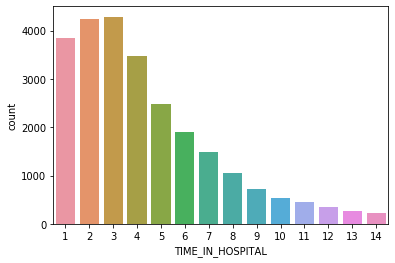

In [35]:
sns.countplot(df2.TIME_IN_HOSPITAL)
plt.show()

Le temps passé à l'hôpital varie de 1 jour à 14 jours.

#### 8. PAYER_CODE : Identifiant entier correspondant à 23 valeurs distinctes, par exemple, Blue Cross / Blue Shield, Medicare et Self-Pay Medical

MC    51.371512
SP    11.311521
BC     9.902514
MD     6.776651
UN     6.460907
HM     5.071634
CP     3.512649
OG     2.099696
CM     1.981292
PO     0.560445
DM     0.477562
WC     0.236808
CH     0.090776
OT     0.082883
MP     0.051308
SI     0.011840
Name: PAYER_CODE, dtype: float64


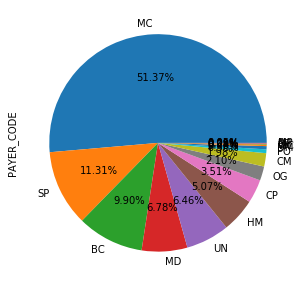

In [36]:
print(df2['PAYER_CODE'].value_counts(1)*100)
df2['PAYER_CODE'].value_counts().plot(kind='pie',autopct='%.2f%%',figsize=(15,5))
plt.show()

Payer_code n'est pas significatif pour la réadmission des patients, nous pouvons donc l'abandonner.

In [37]:
df2.drop(['PAYER_CODE'],axis=1,inplace=True)

#### 9. MEDICAL_SPECIALTY: Identifiant entier d'une spécialité du médecin admettant, correspondant à 55 valeurs distinctes, par exemple, cardiologie, médecine interne, médecine familiale / médecine générale et chirurgien

In [38]:
df2.MEDICAL_SPECIALTY.nunique()

55

In [39]:
df2.MEDICAL_SPECIALTY.value_counts(1)*100

Emergency/Trauma                     27.035561
InternalMedicine                     22.465170
Family/GeneralPractice               10.668193
Cardiology                            8.777677
Surgery-General                       6.709555
Radiologist                           4.033627
Nephrology                            3.378458
Orthopedics                           3.331097
Surgery-Vascular                      1.326124
Gastroenterology                      1.211667
Surgery-Cardiovascular/Thoracic       1.203773
Pulmonology                           1.191933
ObstetricsandGynecology               1.089316
Urology                               1.034061
Psychiatry                            0.891976
Orthopedics-Reconstructive            0.793306
Surgery-Neuro                         0.682796
Neurology                             0.607807
Oncology                              0.588073
Podiatry                              0.323637
Psychology                            0.264435
Hematology   

#### 10. NUM_LAB_PROCEDURES: Nombre de tests de laboratoire effectués pendant la rencontre

In [40]:
print('Le nombre de tests de laboratoire qu\'un patient a subi peut aller de',df2.NUM_LAB_PROCEDURES.min(),'à',df2.NUM_LAB_PROCEDURES.max())

Le nombre de tests de laboratoire qu'un patient a subi peut aller de 1 à 132


#### 11. NUM_PROCEDURES: Nombre de procédures (autres que les tests de laboratoire) effectuées pendant la rencontre

In [41]:
df2.NUM_PROCEDURES.value_counts()

0    10273
1     5659
2     3426
3     2530
6     1471
4     1176
5      802
Name: NUM_PROCEDURES, dtype: int64

Le nombre de procédures va de 0 à 5

#### 12. NUM_MEDICATIONS: Nombre de noms génériques distincts administrés pendant la rencontre

In [42]:
print('Le nombre de médicaments varie d\'un minimum de',df2.NUM_MEDICATIONS.min(),'à un maximum de',df2.NUM_MEDICATIONS.max())

Le nombre de médicaments varie d'un minimum de 1 à un maximum de 81


#### 13. NUMBER_OUTPATIENT: Nombre de visites ambulatoires du patient dans l'année précédant la rencontre

#### 14. NUMBER_EMERGENCY : Nombre de visites d'urgence du patient dans l'année précédant la rencontre

#### 15. NUMBER_INPATIENT: Nombre de visites hospitalières du patient dans l'année précédant la rencontre

#### 16. DIAG_1: Le diagnostic principal (codé comme les trois premiers chiffres de la CIM9)

#### 17. DIAG_2: Diagnostic secondaire (codé comme les trois premiers chiffres de la CIM9)

#### 18. DIAG_3: Diagnostic secondaire supplémentaire (codé comme les trois premiers chiffres de la CIM9)

In [43]:
df2 = df2.reset_index(drop = True )

In [44]:
diag_cols = ['DIAG_1','DIAG_2','DIAG_3']

In [45]:
ord('E'), ord('V')

(69, 86)

In [46]:
for i in diag_cols:
    for j in range(len(df2[i])):
        if str(df2.loc[j, i])[:3] == '250':
            df2.loc[j, i] = 'Diabetes'
        elif ord(str(df2.loc[j, i])[0]) in range(69, 87):
            df2.loc[j, i] = 'External causes of injury'
        elif df2.loc[j, i] == '?':
            df2.loc[j, i] = 'Missing'
        else:
            x = float(df2.loc[j, i])
            if x in range(390, 460) or x == 785:
                df2.loc[j, i] = 'Circulatory'
            elif x in range(460, 520) or x == 786:
                df2.loc[j, i] = 'Respiratory'
            elif x in range(520, 580) or x == 787:
                df2.loc[j, i] = 'Digestive'
            elif x in range(800, 1000):
                df2.loc[j, i] = 'Injury and Poisoning'
            elif x in range(710, 740):
                df2.loc[j, i] = 'Musculoskeletal System and Connective Tissue'
            elif x in range(580, 630) or x == 788:
                df2.loc[j, i] = 'Genitourinary'
            elif x in range(140, 230):
                df2.loc[j, i] = 'Neoplasms'
            elif x in [780, 781, 784] or x in range(790, 800):
                df2.loc[j, i] = 'Other Symptoms'
            elif x in range(240, 280):
                df2.loc[j, i] = 'Endocrine, Nutritional, Metabolic, Immunity'
            elif x in range(680, 710) or x == 782:
                df2.loc[j, i] = 'Skin and Subcutaneous Tissue'
            elif x in range(1, 140):
                df2.loc[j, i] = 'Infectious and Parasitic'
            elif x in range(290, 320):
                df2.loc[j, i] = 'Mental Disorders'
            elif x in range(280, 290):
                df2.loc[j, i] = 'Blood and Blood-Forming Organs'
            elif x in range(320, 360):
                df2.loc[j, i] = 'Nervous'
            elif x in range(630, 680):
                df2.loc[j, i] = 'Pregnancy, Childbirth'
            elif x in range(360, 390):
                df2.loc[j, i] = 'Sense Organs'
            else:
                df2.loc[j, i] = 'Congenital Anomalies'

In [47]:
for i in range(len(df2['DIAG_2'])):
    if df2.loc[i, 'DIAG_2'] == 'Missing':
        if df2.loc[i, 'DIAG_1'] != 'Missing':
            df2.loc[i, 'DIAG_2'] = 'Not Required'

In [48]:
for i in range(len(df2['DIAG_3'])):
    if df2.loc[i, 'DIAG_3'] == 'Missing':
        if df2.loc[i, 'DIAG_2'] == 'Not Required' or df2.loc[i, 'DIAG_2'] != 'Missing':
            df2.loc[i, 'DIAG_3'] = 'Not Required'

In [49]:
df3 = pd.DataFrame(df2['DIAG_1'].value_counts())
df4 = df3.merge(pd.DataFrame(df2['DIAG_2'].value_counts()), how = 'outer', left_index = True, right_index = True)
df4.merge(pd.DataFrame(df2['DIAG_3'].value_counts()), how = 'outer', left_index = True, right_index = True)

,DIAG_1,DIAG_2,DIAG_3
Blood and Blood-Forming Organs,282,701,619
Circulatory,7623,8110,7647
Congenital Anomalies,210,146,110
Diabetes,2183,2918,4339
Digestive,2244,1090,951
"Endocrine, Nutritional, Metabolic, Immunity",694,2120,2344
External causes of injury,243,660,1382
Genitourinary,1191,1804,1583
Infectious and Parasitic,557,472,433
Injury and Poisoning,1801,610,488


In [50]:
len(df2[df2['DIAG_1'] == 'Missing'])

0

#### 19. NUMBER_DIAGNOSES: Nombre de diagnostics saisis dans le système

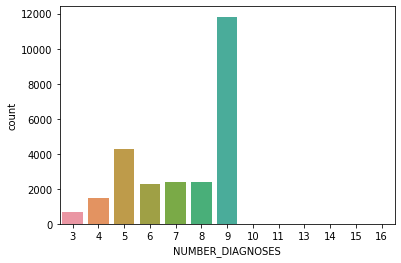

In [51]:
sns.countplot(df2.NUMBER_DIAGNOSES)

Le nombre de diagnostics saisis dans le système va de 1 à 16.

#### 20. MAX_GLU_SERUM: Indique la plage du résultat ou si le test n'a pas été effectué.

Valeurs: "> 200", "> 300", "normal" et "None" si non mesuré   

In [52]:
df2.MAX_GLU_SERUM.value_counts()

None    25335
Norm        2
Name: MAX_GLU_SERUM, dtype: int64

#### 21. A1CRESULT: Indique la plage du résultat ou si le test n'a pas été effectué.

In [53]:
df2.A1CRESULT.value_counts()

None    21217
>8       1914
Norm     1122
>7       1084
Name: A1CRESULT, dtype: int64

Valeurs: "> 8" si le résultat est supérieur à 8%
    
         «> 7» si le résultat est supérieur à 7% mais inférieur à 8%
        
         «Normal» si le résultat est inférieur à 7%
        
         «Aucun» s'il n'est pas mesuré.

#### 22. caractéristiques pour les médicaments :
    
Pour les noms génériques : METFORMIN, REPAGLINIDE, NATEGLINIDE, CHLORPROPAMIDE, GLIMEPIRIDE, ACETOHEXAMIDE, GLIPIZIDE, GLYBURIDE, TOLBUTAMIDE, PIOGLITAZONE, ROSIGLITAZONE, ACARBOSE, MIGLITOL, TROGLITAZONE, TOLAZAMIDE, EXAMIDE, CITOGLIPTON, INSULIN, GLYBURIDE_METFORMIN, GLIPIZIDE_METFORMIN, GLIMEPIRIDE_PIOGLITAZONE, METFORMIN_ROSIGLITAZONE, et METFORMIN_PIOGLITAZONE

La fonction indique si le médicament a été prescrit ou s'il y a eu un changement de posologie.

Valeurs: «up» si la posologie a été augmentée pendant la rencontre

     «Down» si le dosage a été diminué

     «Stable» si la posologie n'a pas changé

     «Non» si le médicament n'a pas été prescrit

In [54]:
meds = ['METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE',
       'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE',
       'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE',
       'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN',
       'GLYBURIDE_METFORMIN', 'GLIPIZIDE_METFORMIN',
       'GLIMEPIRIDE_PIOGLITAZONE', 'METFORMIN_ROSIGLITAZONE',
       'METFORMIN_PIOGLITAZONE']

for i in meds:
       print(i, df2[i].unique())

METFORMIN ['No' 'Steady' 'Up' 'Down']
REPAGLINIDE ['No' 'Steady' 'Up' 'Down']
NATEGLINIDE ['No' 'Steady' 'Down' 'Up']
CHLORPROPAMIDE ['No' 'Steady']
GLIMEPIRIDE ['No' 'Steady' 'Up' 'Down']
ACETOHEXAMIDE ['No']
GLIPIZIDE ['No' 'Steady' 'Down' 'Up']
GLYBURIDE ['No' 'Steady' 'Up' 'Down']
TOLBUTAMIDE ['No']
PIOGLITAZONE ['No' 'Up' 'Steady' 'Down']
ROSIGLITAZONE ['No' 'Steady' 'Up' 'Down']
ACARBOSE ['No' 'Steady' 'Up' 'Down']
MIGLITOL ['No' 'Steady' 'Up' 'Down']
TROGLITAZONE ['No']
TOLAZAMIDE ['No' 'Steady']
EXAMIDE ['No']
CITOGLIPTON ['No']
INSULIN ['Steady' 'No' 'Up' 'Down']
GLYBURIDE_METFORMIN ['No' 'Steady' 'Up' 'Down']
GLIPIZIDE_METFORMIN ['No' 'Steady']
GLIMEPIRIDE_PIOGLITAZONE ['No']
METFORMIN_ROSIGLITAZONE ['No']
METFORMIN_PIOGLITAZONE ['No' 'Steady']


Nous pouvons supprimer examide, citoglipton et metformin-rosiglitazone car ils ne sont pas prescrit à aucun patient.

In [55]:
df2.drop(['EXAMIDE', 'CITOGLIPTON','METFORMIN_ROSIGLITAZONE'], axis = 1, inplace = True)

In [56]:
meds = ['METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE',
       'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE',
       'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE',
       'TOLAZAMIDE', 'INSULIN', 'GLYBURIDE_METFORMIN', 'GLIPIZIDE_METFORMIN',
       'GLIMEPIRIDE_PIOGLITAZONE', 'METFORMIN_PIOGLITAZONE']

In [57]:
# Les médicaments peuvent être codés comme ci-dessous
for i in meds:
    df2[i] = df2[i].replace({'No' : -2,
                           'Down' : -1,
                           'Steady' : 0,
                           'Up' : 1})

In [58]:
for i in meds:
    df2[i] = df2[i].astype('int64')

#### 23. CHANGE :  Indique s'il y a eu un changement dans les médicaments diabétiques (soit la posologie, soit le nom générique)

In [59]:
df2.CHANGE.value_counts()

Ch    13823
No    11514
Name: CHANGE, dtype: int64

In [60]:
df2['CHANGE'] = df2['CHANGE'].replace({'No' : 0, 'Ch' : 1})

#### 24. DIABETESMED : Indique si un médicament diabétique a été prescrit.

In [61]:
df2.DIABETESMED.value_counts()

Yes    20790
No      4547
Name: DIABETESMED, dtype: int64

In [62]:
df2['DIABETESMED'] = df2['DIABETESMED'].replace({'Yes' : 1, 'No' : 0})

#### 25. READMITTED: Outcome variable

Le résultat que nous examinons est de savoir si le patient est réadmis à l'hôpital dans les 30 jours ou non.

In [63]:
df2.READMITTED.value_counts()

NO     14044
>30     8539
<30     2754
Name: READMITTED, dtype: int64

Le résultat a en fait des catégories <30,> 30 et Aucune réadmission. notre problème, nous allons le convertir en 2 catégories, c'est-à-dire pas de réadmission ou de réadmission dans 30 jours

In [64]:
df2['READMITTED'] = df2['READMITTED'].replace('>30', 'NO')
df2['READMITTED']= df2['READMITTED'].replace( {'NO': 0, '<30': 1} ).astype(int)

In [65]:
df2.reset_index(drop = True, inplace = True)

### (ADDITIONAL) Création de nouvelles fonctionnalités et suppression des fonctionnalités redondantes

#### 1. Visites de l'année précédente:
‘NUMBER_OUTPATIENT’, ‘NUMBER_EMERGENCY’, ‘NUMBER_INPATIENT’  ont été combinés en les additionnant pour obtenir le nombre total de visites du patient au cours de l'année précédente, puis en supprimant les fonctionnalités de combinaison.

In [66]:
df2['preceding_year_visits']=df2['NUMBER_OUTPATIENT']+df2['NUMBER_EMERGENCY']+df2['NUMBER_INPATIENT']

In [67]:
# Dropping ‘number_outpatient’, ‘number_emergency’, ‘number_inpatient’
df2 = df2.drop(columns=['NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY','NUMBER_INPATIENT'])

#### 2. Nombre de changements de médicaments

In [68]:
df2['number_changes'] = np.nan
for i in range(len(df2)):
    n = 0
    for j in meds:
        if df2.loc[i, j] == -1 or df2.loc[i, j] == 1:
            n += 1
    df2.loc[i, 'number_changes'] = n

In [69]:
df2['number_changes'].value_counts()

0.0    16388
1.0     8417
2.0      485
3.0       44
4.0        3
Name: number_changes, dtype: int64

#### 3. Nombre de médicaments diabétiques

In [70]:
df2['number_diab_meds'] = np.nan
for i in range(len(df2)):
    n = 0
    for j in meds:
        if df2.loc[i, j] != -2:
            n += 1
    df2.loc[i, 'number_diab_meds'] = n
df2.number_diab_meds=df2.number_diab_meds.astype('int64')
df2['number_diab_meds'].value_counts()

1    11618
2     6017
0     4547
3     2597
4      535
5       22
6        1
Name: number_diab_meds, dtype: int64

#### 4. Insulin_treatment

In [71]:
df2['insulin_treatment'] = np.nan

In [72]:
for i in range(len(df2)):
    if df2.loc[i, 'INSULIN'] != -2 and df2.loc[i, 'number_diab_meds'] == 1:
        df2.loc[i, 'insulin_treatment'] = 'insulin_only'
    elif df2.loc[i, 'INSULIN'] != -2 and df2.loc[i, 'number_diab_meds'] > 1:
        df2.loc[i, 'insulin_treatment'] = 'insulin_combo'
    elif df2.loc[i, 'INSULIN'] == -2 and df2.loc[i, 'number_diab_meds'] == 0:
        df2.loc[i, 'insulin_treatment'] = 'no_med'
    else:
        df2.loc[i, 'insulin_treatment'] = 'other_meds'
df2['insulin_treatment'].value_counts()

insulin_only     8128
insulin_combo    7511
other_meds       5151
no_med           4547
Name: insulin_treatment, dtype: int64

number_diab_meds a été créé pour faire le traitement de l'insuline de la colonne, par conséquent nous le déposons

In [73]:
df2=df2.drop('number_diab_meds',1)
df2.reset_index(drop = True, inplace = True)

### Tests statistiques

In [74]:
# Caractéristiques numériques
num_cols = ['AGE_INT', 'TIME_IN_HOSPITAL', 'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES', 'NUM_MEDICATIONS',
            'NUMBER_DIAGNOSES','preceding_year_visits', 'number_changes']

In [75]:
# Caractéristiques catégoriques
cat_cols = ['RACE', 'GENDER', 'ADMISSION_TYPE', 'DISCHARGE_DISPOSITION', 'ADMISSION_SOURCE',
            'DIAG_1', 'DIAG_2', 'DIAG_3', 'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN', 'REPAGLINIDE', 
            'NATEGLINIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 
            'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
            'TOLBUTAMIDE', 'INSULIN', 'GLYBURIDE_METFORMIN', 'GLIPIZIDE_METFORMIN', 
            'GLIMEPIRIDE_PIOGLITAZONE', 'METFORMIN_ROSIGLITAZONE', 'METFORMIN_PIOGLITAZONE', 
            'CHANGE', 'DIABETESMED', 'insulin_treatment']

In [76]:
df2.shape

(25337, 43)

In [77]:
len(num_cols)+len(cat_cols)

42

#### Chi-2 pour les catégoriques  vs catégoriques et one way anova pour les catégoriques vs numériques

Pour voir si les fonctionnalités sont significatives par rapport à la variable cible (readmitted)

In [78]:
#Statistical Tests (Chi Square and Anova)

p_val = []
sig = []
for i in df2.columns:
    if i in num_cols:
        stat, p = stats.f_oneway(df2[df2['READMITTED'] == 0][i], df2[df2['READMITTED'] == 1][i])
    else:
        ct = pd.crosstab(df2[i], df2['READMITTED'])
        stat, p, dof, exp = stats.chi2_contingency(ct)
    p_val.append(p)
    if p < 0.05:
        sig.append('Significant')
    else:
        sig.append("Insignificant")
stats_df = pd.DataFrame({"columns" : df2.columns, "p_value" : p_val, "significance" : sig})

stats_df.sort_values(by='p_value',ascending = True)

,columns,p_value,significance
39,READMITTED,0.000000e+00,Significant
40,preceding_year_visits,9.387277e-128,Significant
4,DISCHARGE_DISPOSITION,1.277504e-29,Significant
32,INSULIN,2.382848e-22,Significant
14,NUMBER_DIAGNOSES,4.713655e-22,Significant
42,insulin_treatment,2.864962e-19,Significant
7,MEDICAL_SPECIALTY,3.399076e-17,Significant
41,number_changes,4.351799e-17,Significant
38,DIABETESMED,6.021855e-14,Significant
37,CHANGE,3.972180e-13,Significant


In [79]:
sig_cols = stats_df[stats_df['significance'] == 'Significant']['columns'].reset_index(drop = True)
insig_cols = stats_df[stats_df['significance'] == 'Insignificant']['columns'].reset_index(drop = True)
print('Statiscally significant features are :','\n')
print(sig_cols)

Statiscally significant features are : 

0     DISCHARGE_DISPOSITION
1          ADMISSION_SOURCE
2          TIME_IN_HOSPITAL
3         MEDICAL_SPECIALTY
4           NUM_MEDICATIONS
5                    DIAG_1
6                    DIAG_2
7                    DIAG_3
8          NUMBER_DIAGNOSES
9                 A1CRESULT
10                METFORMIN
11             PIOGLITAZONE
12                 MIGLITOL
13                  INSULIN
14                   CHANGE
15              DIABETESMED
16               READMITTED
17    preceding_year_visits
18           number_changes
19        insulin_treatment
Name: columns, dtype: object


Nous pouvons supprimer toutes ces variables

In [80]:
df2 = df2.drop(['NATEGLINIDE','CHLORPROPAMIDE','ACETOHEXAMIDE',  'TOLBUTAMIDE',
              'ACARBOSE', 'MIGLITOL',  'TROGLITAZONE',  'TOLAZAMIDE',
              'GLYBURIDE_METFORMIN',  'GLIPIZIDE_METFORMIN',
              'GLIMEPIRIDE_PIOGLITAZONE','METFORMIN_PIOGLITAZONE'],axis=1)

CHANGE et number_change décrivent les mêmes informations et les deux sont significatives, nous en abandonnons une basée sur le fait que le nombre de changements est un peu plus significatif que le changement.

In [81]:
df2 = df2.drop(['CHANGE'],axis=1)

In [82]:
df2['ADMISSION_TYPE'].value_counts()

Emergency        17387
Elective          7913
Not Available       37
Name: ADMISSION_TYPE, dtype: int64

In [83]:
df2['ADMISSION_SOURCE'].value_counts()

Emergency                                        13287
Referral                                          9637
Transferred from another health care facility     2413
Name: ADMISSION_SOURCE, dtype: int64

ADMISSION_SOURCE et ADMISSION_TYPE sont similaires car les détails de ADMISSION_TYPE sont présents dans l'identifiant de la source d'admission. Nous pouvons donc supprimer ADMISSION_TYPE et simplement conserver ADMISSION_SOURCE

In [84]:
df2 = df2.drop(['ADMISSION_TYPE'],axis=1)

In [85]:
df2.shape

(25337, 29)

In [86]:
df2.columns

Index(['RACE', 'GENDER', 'AGE_INT', 'DISCHARGE_DISPOSITION',
       'ADMISSION_SOURCE', 'TIME_IN_HOSPITAL', 'MEDICAL_SPECIALTY',
       'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES', 'NUM_MEDICATIONS', 'DIAG_1',
       'DIAG_2', 'DIAG_3', 'NUMBER_DIAGNOSES', 'MAX_GLU_SERUM', 'A1CRESULT',
       'METFORMIN', 'REPAGLINIDE', 'GLIMEPIRIDE', 'GLIPIZIDE', 'GLYBURIDE',
       'PIOGLITAZONE', 'ROSIGLITAZONE', 'INSULIN', 'DIABETESMED', 'READMITTED',
       'preceding_year_visits', 'number_changes', 'insulin_treatment'],
      dtype='object')


## Multi-Collinearity


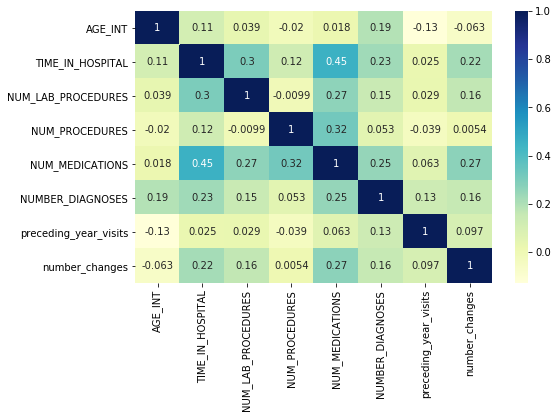

In [87]:
plt.figure(figsize=(8,5))
corr=df2[num_cols].corr()
sns.heatmap(corr,annot=True,cmap='YlGnBu')
b,t=plt.ylim()
plt.ylim(b+0.5,t-0.5)
plt.show()

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=pd.DataFrame()
vif['VIF']=[variance_inflation_factor(df2[num_cols].values,i) for i in range(df2[num_cols].shape[1])]
vif['feature']=df2[num_cols].columns
vif=vif.sort_values('VIF',ascending=False)
vif

,VIF,feature
5,14.765046,NUMBER_DIAGNOSES
0,12.129846,AGE_INT
4,6.855368,NUM_MEDICATIONS
2,5.869225,NUM_LAB_PROCEDURES
1,4.273706,TIME_IN_HOSPITAL
3,1.935540,NUM_PROCEDURES
7,1.688623,number_changes
6,1.280949,preceding_year_visits


Comme on peut le voir à partir de la carte thermique de corrélation et des valeurs de vif, il n'y a pas de multi-colinéarité dans les caractéristiques numériques.

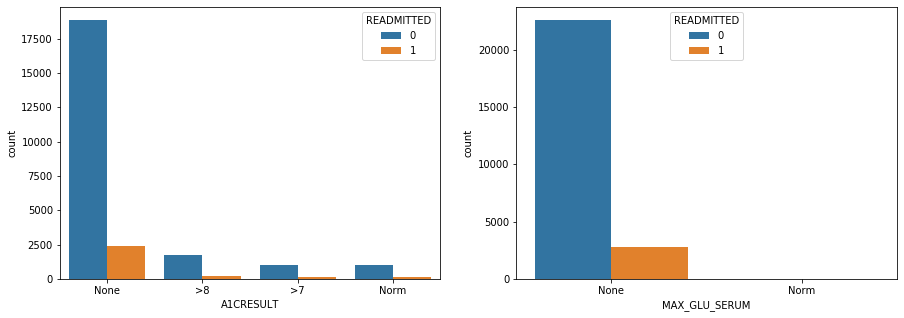

In [89]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax=ax.flatten()
j=0
for i in ['A1CRESULT','MAX_GLU_SERUM']:    
    sns.countplot(df2[i],hue=df2['READMITTED'],ax=ax[j]) 
    j=j+1
plt.show()


Nous pouvons voir que la majorité des patients réadmis n’ont pas subi de test A1C ni de test Max Glucose Serum.

## Outliers et normalité

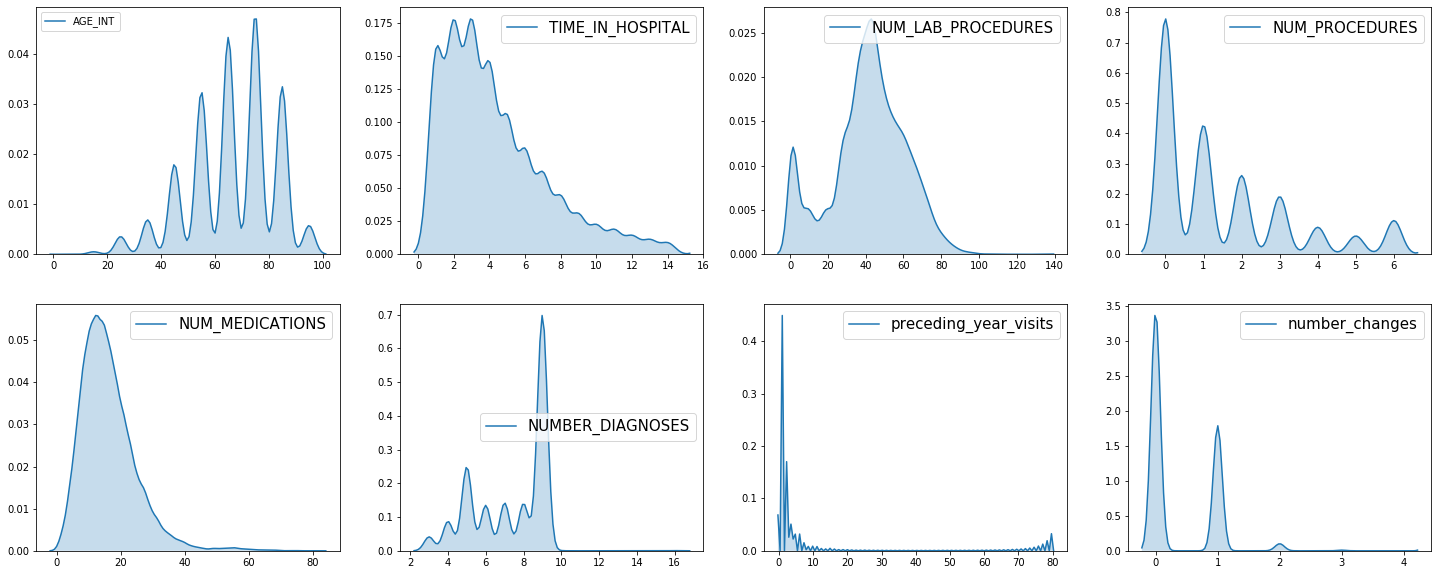

In [90]:
fig,ax=plt.subplots(2,4,figsize=(25,10))
ax=ax.flatten()
j=0
for i in num_cols:    
    sns.kdeplot(df2[i],ax=ax[j],shade=True)
    plt.rc('legend', fontsize=15) 
    j=j+1
plt.show()


In [91]:
#Number of outliers
for i in num_cols:
    q1 = df2[i].quantile(0.25)
    q3 = df2[i].quantile(0.75)
    iqr = q3-q1

    UL = q3 + (1.5 * iqr)
    LL = q1 - (1.5 * iqr)
    print(i,df2[(df2[i]>UL) | (df2[i]<LL)].count()[i])
    #print(X[(X[i]>UL) | (X[i]<LL)][i])


AGE_INT 69
TIME_IN_HOSPITAL 488
NUM_LAB_PROCEDURES 53
NUM_PROCEDURES 1471
NUM_MEDICATIONS 722
NUMBER_DIAGNOSES 9
preceding_year_visits 3778
number_changes 47


Les données ne sont pas normalement distribuées et ont peu de valeurs aberrantes, nous utilisons donc la transformation.

In [92]:
pt = PowerTransformer(method = 'yeo-johnson')
df_new=df2.copy()
df_new[num_cols]=pd.DataFrame(pt.fit_transform(df_new[num_cols]), columns = num_cols)
skew_df = pd.DataFrame({"Skew_Before" : df2[num_cols].skew(), "Skew_After" : df_new[num_cols].skew()})
skew_df

,Skew_Before,Skew_After
AGE_INT,-0.517891,-0.104587
TIME_IN_HOSPITAL,1.128727,0.012535
NUM_LAB_PROCEDURES,-0.290458,-0.283152
NUM_PROCEDURES,1.195864,0.131387
NUM_MEDICATIONS,1.496423,0.019794
NUMBER_DIAGNOSES,-0.592813,-0.189704
preceding_year_visits,7.121517,0.420725
number_changes,1.086956,0.619423


### Scaling 

In [93]:
mm=MinMaxScaler()
df_new[num_cols]=pd.DataFrame(mm.fit_transform(df_new[num_cols]), columns = num_cols)

In [94]:
df2.to_csv('CSV_Files/Diabetes_cleaned.csv', index = False)